# Exploring TFRecords

last updated: 03-22-2022

In [1]:
cd ../..

/home/cridonoso/Documents/astromer


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from core.data import load_dataset, \
                      pretraining_pipeline, \
                      inference_pipeline

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-03-22 12:18:40.252748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 12:18:40.252776: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Pretraining format

In [3]:
records_path = './data/records/alcock/fold_0/alcock/'

`load_dataset` only open the dataset in its raw format. In this case, we deserialize tfrecords file to tensors. We can also use `load_numpy` which receive a list of numpy arrays.

In [4]:
raw_dataset = load_dataset(os.path.join(records_path, 'test'), 
                           repeat=1, shuffle=False)

2022-03-22 12:18:44.829128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 12:18:44.829152: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 12:18:44.829167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (appa): /proc/driver/nvidia/version does not exist
2022-03-22 12:18:44.829431: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


`pretraining_pipeline()` modifies our dataset to match the ASTROMER training strategy -i.e., masking technique.

In [5]:
dataset = pretraining_pipeline(raw_dataset, 
                               batch_size=256, 
                               max_obs=200, 
                               msk_frac=0.5, 
                               rnd_frac=0.2, 
                               same_frac=0.2)
objects = pd.read_csv(os.path.join(records_path, 'objects.csv'))
objects

[INFO] Pretraining mode. Random 200-len windows


,label,size
0,Cep_0,1082
1,Cep_1,583
2,EC,6724
3,LPV,2946
4,RRab,7297
5,RRc,1662


here we visualize an input sample

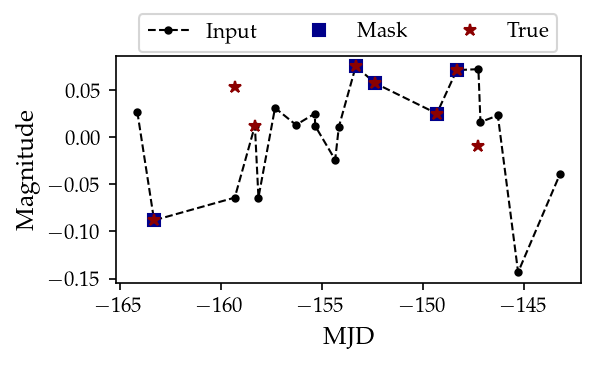

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, 
                         dpi=150)
lim = 20
start = 0

for i, (batch, (target, _, mask)) in enumerate(dataset):
    x_input  = batch['input'][-1][start:start+lim]
    t_sample = batch['times'][-1][start:start+lim]
    x_output = target[-1][start:start+lim]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1][start:start+lim])
    mask_out = tf.squeeze(mask[-1][start:start+lim])


    times_masked = tf.boolean_mask(t_sample, mask_in)
    serie_masked = tf.boolean_mask(x_input, mask_in)


    times_masked_out = tf.boolean_mask(t_sample, mask_out)
    serie_masked_out = tf.boolean_mask(x_input, mask_out)

    axes.plot(t_sample, x_output, color='k', linestyle='--', marker='.', label='Input', linewidth=1)
    axes.plot(times_masked, serie_masked, marker='s', linestyle='', color='darkblue', label='Mask', linewidth=1)
    axes.plot(times_masked_out, serie_masked_out, color='darkred', linestyle='', marker='*', label='True', linewidth=1)

    axes.set_xlabel('MJD', fontsize=12)
    axes.set_ylabel('Magnitude', fontsize=12)    
    axes.legend(ncol=3, bbox_to_anchor=(0.97, 1.23))
    break

In [23]:
# fig.savefig('./presentation/figures/input.pdf', format='pdf', bbox_inches='tight')

### Inference format

The `inference_pipeline` divides light curves in 200-len adjacent windows. We do not use the masking here as at this point we need to codify every single observation within the light curve.

Notice we can use the same loaded raw dataset (`raw_dataset`)

In [40]:
dataset = inference_pipeline(raw_dataset, 
                             batch_size=10, 
                             max_obs=200, 
                             n_classes=1,
                             shuffle=True, 
                             drop_remainder=False)

[INFO] Inference mode. Cutting 200-len windows


`inference_pipeline()` was made to be use on classification, that is why we can specify the number of classes (`n_classes=1`). If we are using an unlabeled dataset, just leave it as the default.

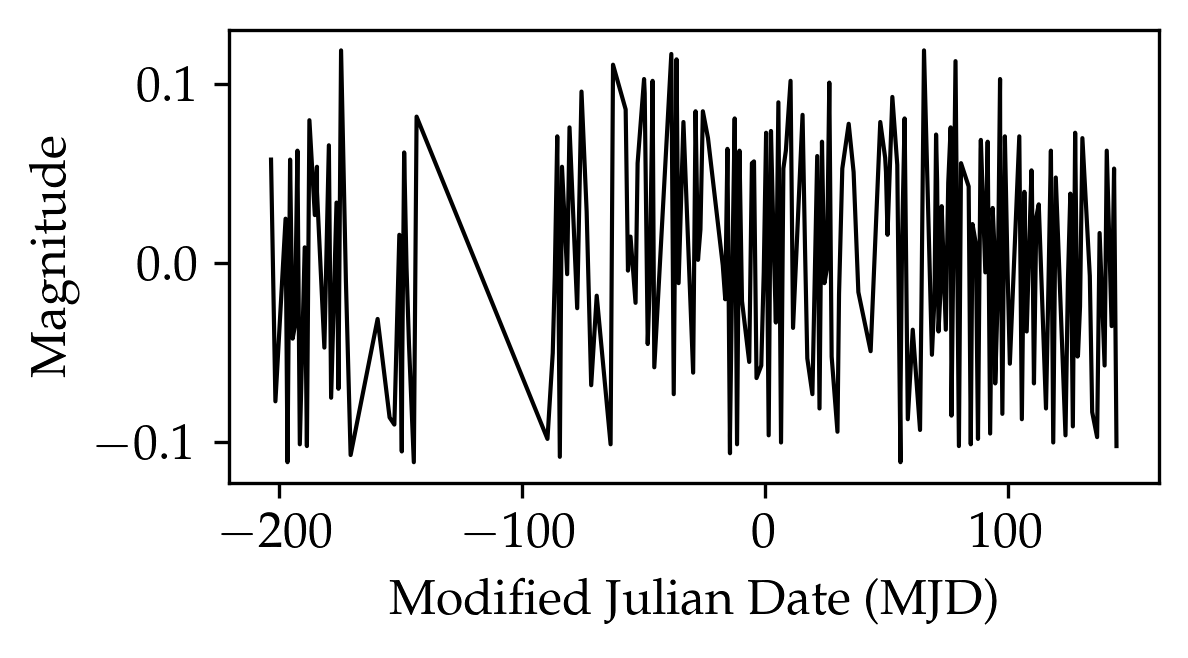

In [46]:
fig, axes = plt.subplots(1, 1, figsize=(4,2), sharex=True, sharey=True, 
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, 
                         dpi=300)
    
for batch, (y, y_label, mask) in dataset.take(1):
    x_input  = batch['input'][-1]
    t_sample = batch['times'][-1]
    
    mask_in  = tf.squeeze(batch['mask_in'][-1])

    times_masked = tf.boolean_mask(t_sample, 1.-mask_in)
    serie_masked = tf.boolean_mask(x_input, 1.-mask_in)
    
    
    # Lightcurve
    axes.plot(times_masked, serie_masked, color='k', linestyle='-', marker='', label='Input', linewidth=1)

    axes.set_xlabel('Modified Julian Date (MJD)')
    axes.set_ylabel('Magnitude')   
    plt.show()
